In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [2]:
def download_dataset_to_custom_dir(dataset_handle: str, target_parent_dir: str):
    # Baixa o dataset (isso cria uma subpasta com número da versão, ex: .../2/)
    downloaded_path = kagglehub.dataset_download(dataset_handle)

    # Extrai o nome do dataset (última parte do handle)
    dataset_name = dataset_handle.split("/")[-1]

    # Caminho final desejado: ../datasets/unsupervised-learning-on-country-data/
    target_dir = os.path.join(target_parent_dir, dataset_name)

    # Garante que a pasta ../datasets/ existe
    os.makedirs(target_parent_dir, exist_ok=True)

    # Remove destino se já existir
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Move a pasta baixada para o destino desejado
    shutil.move(downloaded_path, target_dir)

    print(f"✅ Dataset baixado para: {target_dir}")
    return target_dir

# ===== Download do dataset =====
dataset_path = download_dataset_to_custom_dir(
    "rohan0301/unsupervised-learning-on-country-data",
    "../datasets"
)

100%|██████████| 5.21k/5.21k [00:00<00:00, 10.6MB/s]

Extracting model files...
✅ Dataset baixado para: ../datasets\unsupervised-learning-on-country-data


In [3]:
# Carregar o arquivo CSV do dataset baixado
# ===== Leitura do CSV com pandas =====
csv_path = os.path.join(dataset_path, "Country-data.csv")
df = pd.read_csv(csv_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# Separando as colunas numéricas (se necessário)
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

# Instanciando o scaler
scaler = StandardScaler()

# Aplicando o scaler (fit + transform) nas colunas numéricas
df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

# Calcular o número de países diferentes
num_countries = df['country'].nunique()
print(f"Número de países diferentes no dataset: {num_countries}")

Número de países diferentes no dataset: 167


Estatísticas de faixa dinâmica / quartis:
                 min        q1    median        q3       max  amplitude
child_mort -0.887138 -0.746619 -0.471798  0.592667  4.221297   5.108436
exports    -1.500192 -0.633337 -0.223528  0.374720  5.813835   7.314027
health     -1.827827 -0.692211 -0.181001  0.651541  4.047436   5.875262
imports    -1.939940 -0.691479 -0.148743  0.491353  5.266181   7.206120
income     -0.860326 -0.717456 -0.373808  0.294237  5.611542   6.471868
inflation  -1.137852 -0.566641 -0.226950  0.281636  9.129718  10.267570
life_expec -4.337186 -0.592758  0.286958  0.704258  1.380962   5.718149
total_fer  -1.191250 -0.763902 -0.356431  0.617525  3.009349   4.200600
gdpp       -0.696801 -0.636660 -0.454431  0.059421  5.036507   5.733307


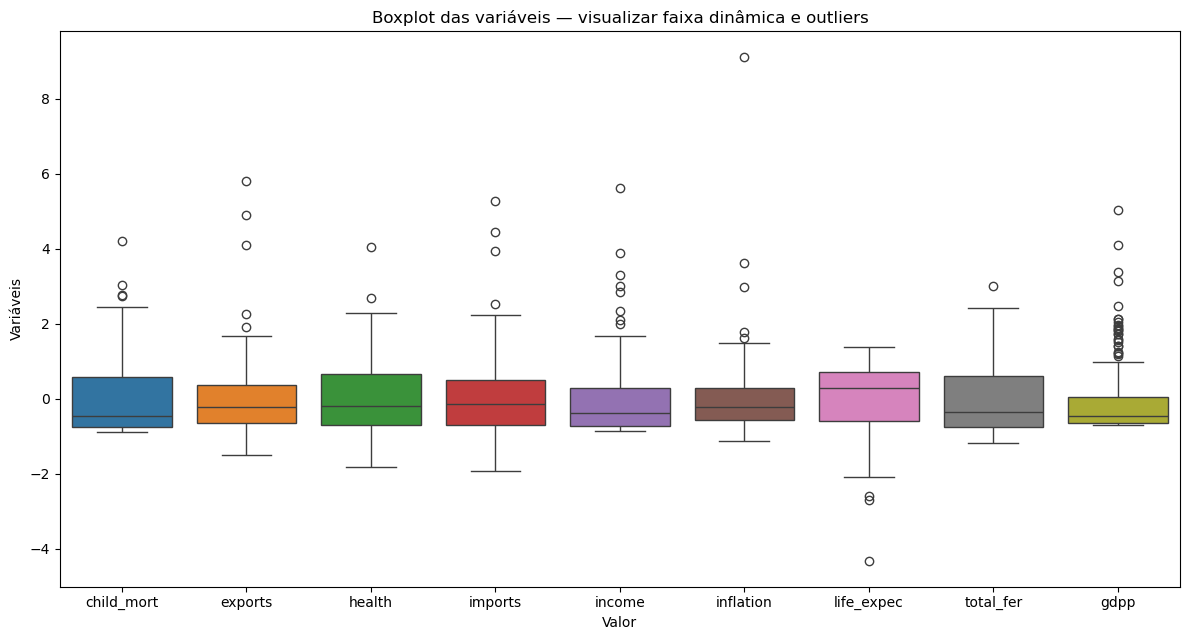

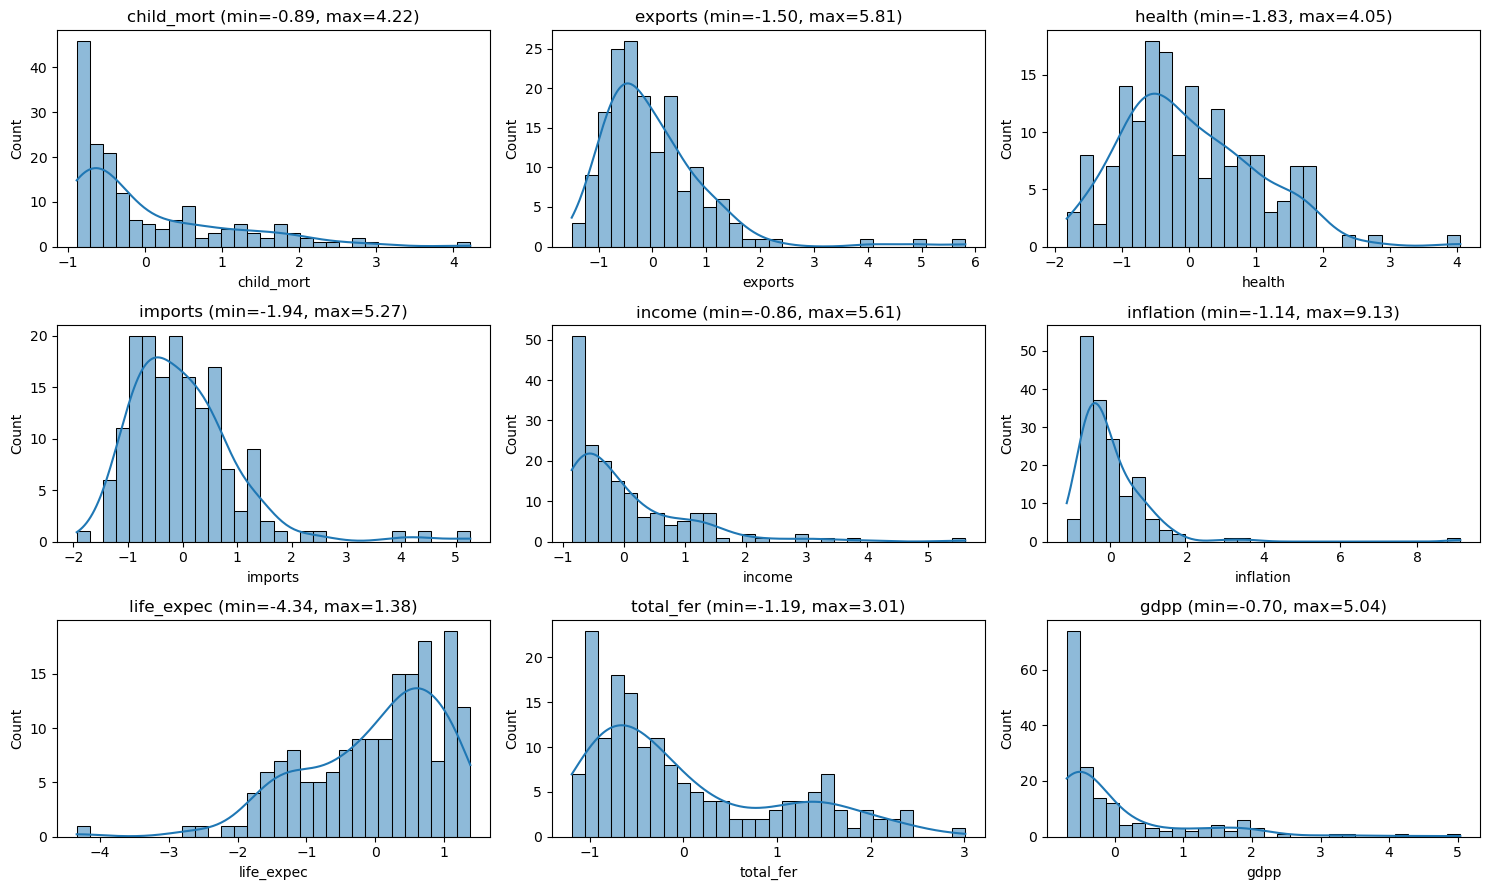

In [6]:
def plot_dynamic_range(df, cols=None, figsize=(12, 6)):
    """
    Plota boxplots e histogramas para ver a faixa dinâmica das colunas numéricas.
    """
    if cols is None:
        # selecionar todas as colunas numéricas (excluindo identificadores)
        cols = df.select_dtypes(include='number').columns.tolist()
    else:
        # garantir que só use colunas que existam e sejam numéricas
        cols = [c for c in cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # Estatísticas de faixa
    stats = {}
    for c in cols:
        v = df[c].dropna()
        stats[c] = {
            'min': float(v.min()),
            'q1': float(v.quantile(0.25)),
            'median': float(v.median()),
            'q3': float(v.quantile(0.75)),
            'max': float(v.max()),
            'amplitude': float(v.max() - v.min())
        }
    stats_df = pd.DataFrame(stats).T
    print("Estatísticas de faixa dinâmica / quartis:")
    print(stats_df)
    
    # Plotagem: boxplots lado a lado
    plt.figure(figsize=(figsize[0], len(cols)*0.5 + 2))
    sns.boxplot(data=df[cols], orient='v')
    plt.title("Boxplot das variáveis — visualizar faixa dinâmica e outliers")
    plt.xlabel("Valor")
    plt.ylabel("Variáveis")
    plt.tight_layout()
    plt.show()
    
    # Para cada variável, plotar histograma + densidade
    n = len(cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows * 3))
    for i, c in enumerate(cols):
        ax = plt.subplot(nrows, ncols, i+1)
        sns.histplot(data=df, x=c, kde=True, bins=30)
        ax.set_title(f"{c} (min={stats[c]['min']:.2f}, max={stats[c]['max']:.2f})")
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Colunas que usaremos para clusterização (exemplo: todas menos “country”)
cols_for_cluster = ["child_mort", "exports", "health", "imports",
                    "income", "inflation", "life_expec", "total_fer", "gdpp"]

stats_df = plot_dynamic_range(df, cols=cols_for_cluster)
# Você pode salvar stats_df, ou usá-lo para ajustar escalas, normalização etc.
    


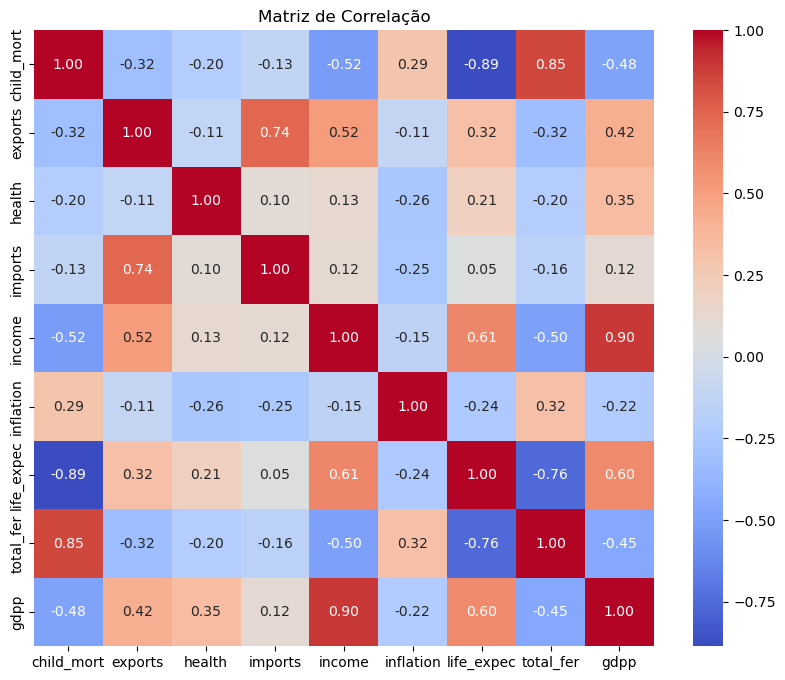

In [7]:
# Calculando a correlação (excluindo a coluna 'country' que é categórica)
correlation = df.drop(columns=['country']).corr()

# Visualizando a correlação com heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(df[colunas_numericas])

c:\Users\Gui\.conda\envs\infnet-algclust-pd-3124\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:
df['cluster'] = kmeans.labels_
df.head(2)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,2
1,Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0


In [10]:
df['cluster'].value_counts()

cluster
0    86
2    45
1    36
Name: count, dtype: int64

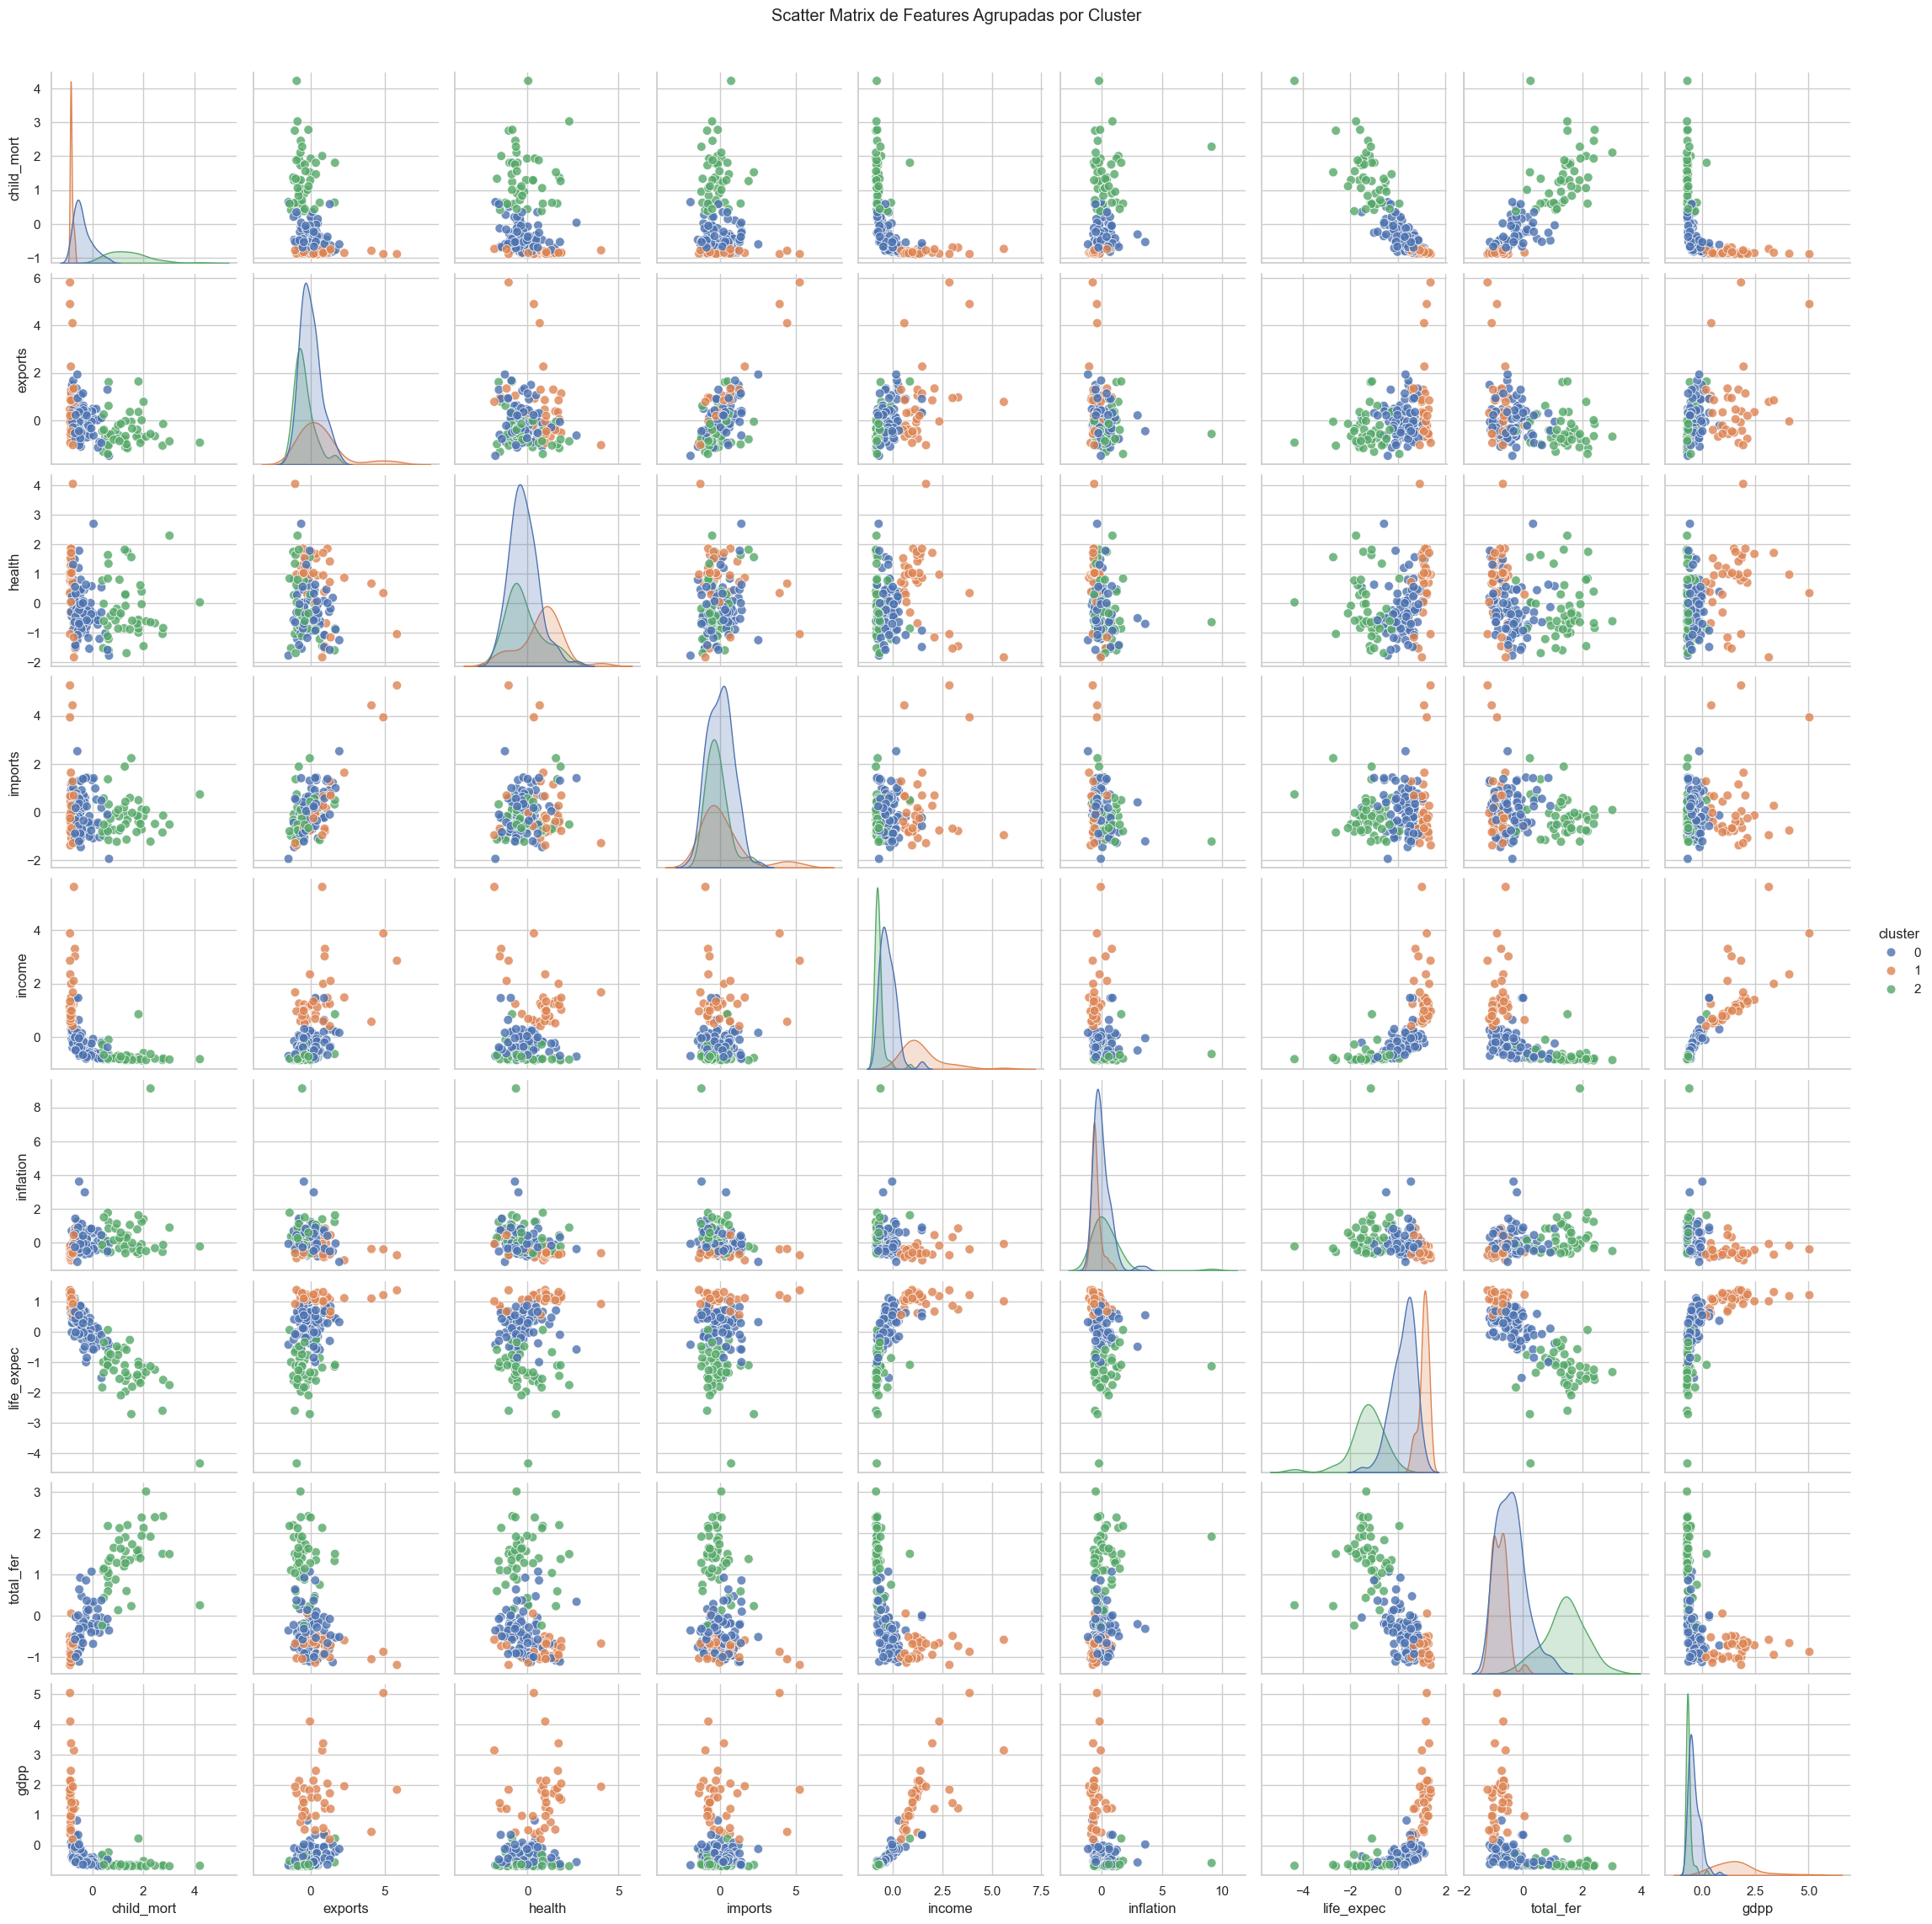

In [11]:
# Gera o pairplot com seaborn
sns.set(style="whitegrid")
pair_plot = sns.pairplot(df, 
                         hue="cluster", 
                         palette="deep",
                         plot_kws={"alpha": 0.8, "s": 60},
                         diag_kind="kde")

pair_plot.fig.suptitle("Scatter Matrix de Features Agrupadas por Cluster", y=1.02)
plt.show()

In [12]:
# Separa apenas as colunas numéricas para o PCA (excluindo 'country' e 'cluster')
features = df.drop(columns=["country", "cluster"])

# Aplica PCA para reduzir para 2 componentes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# Cria um novo DataFrame com os componentes principais
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["cluster"] = df["cluster"]
pca_df["country"] = df["country"]

In [13]:
print("Variância explicada por componente:", pca.explained_variance_ratio_)

Variância explicada por componente: [0.4595174  0.17181626]


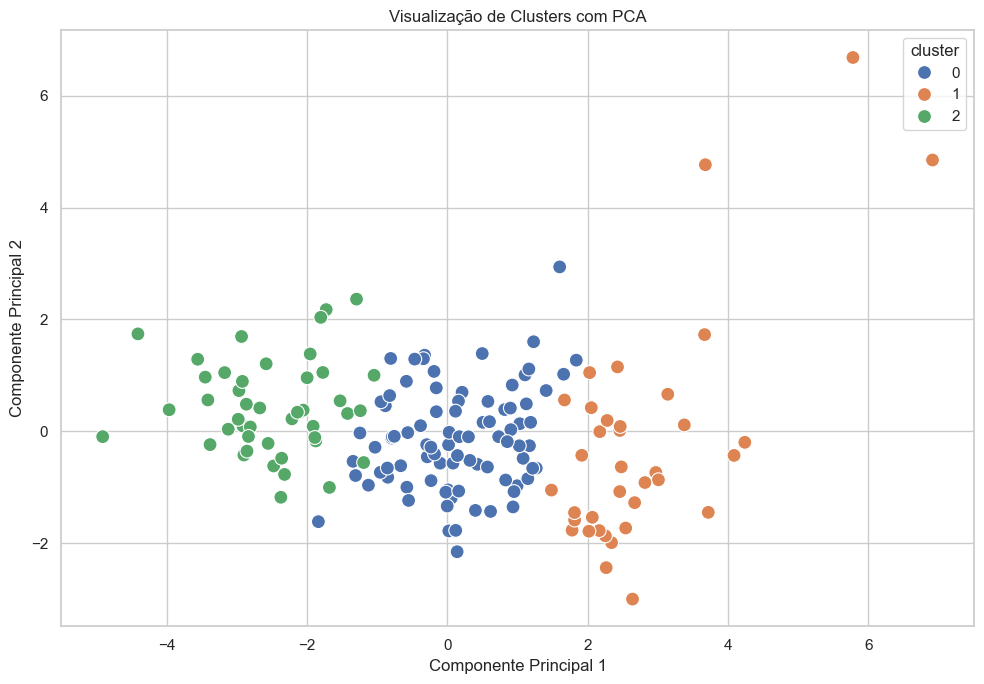

In [16]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="deep",
    s=100
)

# Adiciona os nomes dos países (se quiser)
#for i in range(len(pca_df)):
#    plt.text(pca_df["PC1"][i] + 0.05, pca_df["PC2"][i] + 0.05, pca_df["country"][i], fontsize=9)

plt.title("Visualização de Clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# 4. Cria o gráfico interativo
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="cluster",
    hover_name="country",
    title="Clusters de Países com PCA (Plotly)",
    labels={"cluster": "Cluster"},
    width=800,
    height=600
)

fig.update_layout(template="plotly_dark")
fig.show()